# Histopathologic Cancer Detection

Project for HPI SS2020 for the Deep Learning lecture

## Authors:
* Nicolas Alder (Master Data Engineering, Hasso Plattner Institute)
* Eric Fischer (Master Data Engineering, Hasso Plattner Institute)
* Erik Langenhan (Master IT Systems Engineering, Hasso Plattner Institute)
* Nataniel Müller (Master Digital Health, Hasso Plattner Institute)
* Christian Warmuth (Master Data Engineering, Hasso Plattner Institute)
* Simon Witzke (Master Data Engineering, Hasso Plattner Institute)

## Assignment
Histopathologic cancer detection on hematoxylin and eosin (H\&E)-stained lymph node sections slides following the [Kaggle challenge](https://www.kaggle.com/c/histopathologic-cancer-detection).

We used the [PCam dataset](https://github.com/basveeling/pcam) and evaluated different deep learning network architectures. 

## GitHub
[https://github.com/tranic/dl_histopathology_cancer_detection](https://github.com/tranic/dl_histopathology_cancer_detection)

## Experiment Logs
[neptune.ai project](https://ui.neptune.ai/elangenhan/hcd-experiments/experiments?viewId=5ed22760-b849-410f-be45-ef4339f35100)



# PREPARATION

We import our framework and data from Google Drive ([you can view the folder here](https://drive.google.com/drive/folders/1_fpvo_efsuaXBLyp1yOoPEoEL1811_OZ?usp=sharing)). Data is moved to a ramdisk and unpacked there to have fast access to the images.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
! [ ! -z "$COLAB_GPU" ] && pip install torch skorch && pip install neptune-client

!cp "drive/My Drive/dl_project_data/repo/data_loading.py" .
!mkdir ./helper_scripts/
!cp "drive/My Drive/dl_project_data/repo/helper_scripts/visual_helpers.py" ./helper_scripts
!cp "drive/My Drive/dl_project_data/repo/architecture.py" .
!cp "drive/My Drive/dl_project_data/repo/model_training.py" .
!mkdir data
!cp "drive/My Drive/dl_project_data/train/0.tar" ./data/; tar -xf "./data/0.tar" -C ./data/; rm "./data/0.tar"

!mkdir ./train/
# Creates RAM-Disk for potential speed-up
!sudo mount -t tmpfs -o size=7g tmpfs train

## Use the lower line if you want to train on the full dataset and not only a batch of 20.000 images
!for i in 0; do cp "drive/My Drive/dl_project_data/train/$i.tar" ./train/; tar -xf "./train/$i.tar" -C ./train/; rm "./train/$i.tar"; done;
#!for i in 0 1 2 3 4 5 6 7 8 9 10 11; do cp "drive/My Drive/dl_project_data/train/$i.tar" ./train/; tar -xf "./train/$i.tar" -C ./train/; rm "./train/$i.tar"; done;

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 92kB 2.3MB/s 
     |████████████████████████████████| 829kB 8.0MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 204kB 16.1MB/s 
     |████████████████████████████████| 163kB 16.2MB/s 
     |████████████████████████████████| 143kB 16.9MB/s 
     |████████████████████████████████| 133kB 14.3MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.4.119-py2.py3-none-any.whl size=150019 sha256=997570f9c9fb4598df0d22695ad04d9ad61efaabe7956993e64ba0d3eece2e42
  Stored in directory: /root/.cache/pip/wheels/84/5c/c1/a81e80761b94b4467fd3fda1fd3109463702f6247fc422eb33
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=18b6dbce8b93ed7b858dbb19962a929cde324adbd2856548dae24604b5ed0a1e
  Stored in direc

In [3]:
# IMPORTS
from collections import OrderedDict

import torch
from torch import nn
from torchvision import models, transforms

import architecture as arch
import os
import skimage.io as io
from data_loading import HistopathDataset
import matplotlib.pyplot as plt
import numpy as np

import skorch.callbacks as scb
from skorch import NeuralNetBinaryClassifier
from sklearn import metrics

import model_training as md
import architecture as arch
from data_loading import ToTensor, Normalize, RandomRotation, RandomHorizontalFlip

# Skorch uses some depricated scikit code - works just fine, so surpress warnings for clean output
import warnings
warnings.filterwarnings('ignore')

# TRAINING

For trying out the architectures we used Google Colab. For the final experiment runs we used a server with multiple Nvidia Tesla GPUs.

The architectures we implemented were VGG11, VGG19, ResNet18, ResNet152, DenseNet121 and DenseNet201. An exemplary training of a ResNet18 is shown in the following cells with a small subset of the data.

Our training colab notebooks can be viewed here:
* [VGGNet11](https://colab.research.google.com/drive/1lfhyK8n9yQuLZ3IC5TGXTAszDZ2MdEAq?usp=sharing)
* [VGGNet19](https://colab.research.google.com/drive/12nWoFbQWahVAjyh1iRCav0hV-EgHjxKB?usp=sharing)
* [ResNet18](https://colab.research.google.com/drive/1haDoIiA51HftiioXyFWYMi_tIj3wIDSY?usp=sharing)
* [ResNet152](https://colab.research.google.com/drive/1UrwvLjxo9StS9NUIj1sGOwO9LurMOal1?usp=sharing)
* [DenseNet121](https://colab.research.google.com/drive/17xaj6wSZunO4TxkJ_E457dwpdwy3X6Qu?usp=sharing)
* [DenseNet201](https://colab.research.google.com/drive/1iCdhbz7fglXh07hDT9IBzGAZD5o30jLp?usp=sharing)

## CLASSIFIER PARAMETRIZATION

Here we are able to parametrize our model and set loss, optimizer, learning rate, etc. 

For further information on what can be set and how, please refer to the [skorch documentation](https://skorch.readthedocs.io/en/stable/classifier.html#skorch.classifier.NeuralNetClassifier).

In [4]:
# CLASSIFIER PARAMETRIZATION
classifier = NeuralNetBinaryClassifier(
    arch.ResNet18_96,
    optimizer = torch.optim.Adam, 
    max_epochs = 10,
    lr = 0.01,
    batch_size = 128,
    iterator_train__shuffle = True, # Shuffle training data on each epoch
    train_split = None,
    callbacks = [scb.LRScheduler(policy = 'ExponentialLR', gamma = 0.9)], 
    device ='cuda')

## CLASSIFIER TRAINING

After you have added the shared folder with the data to your drive as a shortcut, you should not have to change anything here. At least for now.


In [6]:
# CLASSIFIER TRAINING
md.train_model(classifier, 
            train_labels = "drive/My Drive/dl_project_data/train/train_split_small.csv", 
            test_labels = "drive/My Drive/dl_project_data/train/test_split_small.csv", 
            file_dir = "train", 
            train_transform = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(),  # TODO: model expects normalized channel values (substract means)
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20),
                                  transforms.ToTensor()]),
            test_transform = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor()]),
            in_memory = False,
            output_path = ".",
            #output_path = "drive/My Drive/dl_project_data/output",
            #logger = {
            #    "api_token": NEPTUNE_API_TOKEN,
            #    "project_qualified_name": NEPTUNE_PROJECT_NAME,
            #    "experiment_name": "ResNet18"
            #}
)

Starting Training for <class 'architecture.ResNet18_96'> 
          Model-Params:
              Criterion:     <class 'torch.nn.modules.loss.BCEWithLogitsLoss'>
              Optimizer:     <class 'torch.optim.adam.Adam'>
              Learning Rate: 0.01
              Epochs:        10
              Batch size:    128
              


  epoch    train_acc    train_f1    train_loss    train_precision    train_recall    train_roc_auc    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc      dur
-------  -----------  ----------  ------------  -----------------  --------------  ---------------  -----------  ----------  ------------  -----------------  --------------  ---------------  -------
      1       0.7728      0.7028        0.5199             0.7374          0.6713           0.8360       0.7882      0.7471        0.4843             0.7303          0.7647           0.8607  67.5515


      2       0.8201      0.7664        0.4284             0.7976          0.7375           0.8806       0.7099      0.7094        0.8250             0.6010          0.8655           0.8465  67.9000


      3       0.8259      0.7756        0.4077             0.8008          0.7519           0.8912       0.8325      0.7816        0.3867             0.8373          0.7329           0.9039  67.7703


      4       0.8357      0.7902        0.3842             0.8076          0.7736           0.9038       0.7309      0.5354        0.6368             0.9118          0.3790           0.8332  68.1439


      5       0.8354      0.7892        0.3892             0.8089          0.7705           0.9033       0.8472      0.8134        0.3566             0.8127          0.8142           0.9181  67.9117


      6       0.8402      0.7954        0.3769             0.8157          0.7760           0.9096       0.8067      0.7405        0.4523             0.8213          0.6742           0.8671  68.3551


      7       0.8467      0.8047        0.3657             0.8204          0.7897           0.9146       0.7594      0.6012        0.5564             0.9343          0.4432           0.8623  67.7871


      8       0.8482      0.8067        0.3519             0.8226          0.7913           0.9202       0.7882      0.6698        0.4750             0.9247          0.5251           0.8948  68.4959


      9       0.8542      0.8133        0.3408             0.8340          0.7936           0.9252       0.8225      0.7386        0.3758             0.9287          0.6131           0.9296  67.6405


     10       0.8624      0.8243        0.3313             0.8428          0.8066           0.9292       0.7152      0.7366        0.6949             0.5924          0.9737           0.9232  68.2578


Saving model...
Saving completed...


# TRAINING RESULT LOGGING

We tracked our training results using [neptune.ai](https://neptune.ai/). The complete list of our final results can be viewed [here](https://ui.neptune.ai/elangenhan/hcd-experiments/experiments?viewId=9ed5b62a-b40b-45fa-b091-81d23be85546).

![Screenshot of neptune.ai with some of our experiments](https://i.imgur.com/7kEt4zu.jpg)


# RESULTS

In this section we will have a look at three of our already trained models as an example, namely ResNet18, Densenet121 and VGGNet11. We will not plot the values of the example network we trained in the previous section.

In [7]:
def load_net(name, uid, module):
  net = NeuralNetBinaryClassifier(
      module=module
  )
  net.initialize()
  net.load_params(
      f_params=f'drive/My Drive/dl_project_data/models/{name}/{uid}-model.pkl', 
      f_optimizer=f'drive/My Drive/dl_project_data/models/{name}/{uid}-opt.pkl', 
      f_history=f'drive/My Drive/dl_project_data/models/{name}/{uid}-history.json'
      )
  return net

## FUNCTION DECLARATIONS FOR TEST METRICS AND PLOTTING

In [12]:
from enum import Enum
class Color(Enum):
     ResNet18 = "#0070C0"
     DenseNet121 = "#F29F05"
     VGGNet11 = "#A4D955"


from matplotlib.pyplot import figure
import seaborn as sns


def get_scores(net, dataset):
  target = [y for _, y in dataset]
  y_hat = net.predict(dataset)
  accuracy = metrics.accuracy_score(target, y_hat)
  precision = metrics.precision_score(target, y_hat)
  recall = metrics.recall_score(target, y_hat)
  f1 = metrics.f1_score(target, y_hat)

  y_proba = net.predict_proba(dataset)
  roc_auc = metrics.roc_auc_score(target, y_proba[:, 1])

  return {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1,
      "roc_auc": roc_auc
  }


def plot_metrics(scores):
  sns.set()
  plt.rcParams.update(plt.rcParamsDefault)

  fig, ax = plt.subplots(3, 2, figsize=(10,8))
  fig.subplots_adjust(wspace = 0.5, hspace = 0.5)

  def plot_single(axis, data, label, net_name, index):
    axis.bar(index, data, label=net_name, color=Color[net_name].value)
    axis.set(title=label, ylabel=label)
    axis.grid(color='grey', linestyle=':', linewidth=0.4)
    axis.set_ylim(0.96, 1.0)
    axis.get_xaxis().set_ticks([])
    axis.legend()

  i = 0
  for net_name in scores:
    plot_single(ax[0,0], scores[net_name]['accuracy'], 'Test Accuracy', net_name, i)
    plot_single(ax[0,1], scores[net_name]['f1'], 'Test F1 Score', net_name, i)
    plot_single(ax[1,0], scores[net_name]['precision'], 'Test Precision', net_name, i)
    plot_single(ax[1,1], scores[net_name]['recall'], 'Test Recall', net_name, i)
    plot_single(ax[2,0], scores[net_name]['roc_auc'], 'Test AUROC', net_name, i)
    ax[-1, -1].axis('off')
    i = i + 1

  fig.tight_layout()
  
  plt.show()


def plot_history(nets):
  sns.set()
  plt.rcParams.update(plt.rcParamsDefault)

  fig, ax = plt.subplots(3, 2, figsize=(10,8))
  fig.subplots_adjust(wspace = 0.5, hspace = 0.5)


  def plot_history_single(axis, data, label, net_name):
    axis.plot(data, color=Color[net_name].value, label=net_name)
    axis.set(title=label, xlabel="Epoch")
    axis.grid(color='grey', linestyle=':', linewidth=0.4)
    axis.legend()

  for net_name, net in nets:
    plot_history_single(ax[0,0], net.history[:, ('valid_acc')], 'Test Accuracy', net_name)
    plot_history_single(ax[0,1], net.history[:, ('valid_f1')], 'Test F1 Score', net_name)
    plot_history_single(ax[1,0], net.history[:, ('valid_precision')], 'Test Precision', net_name)
    plot_history_single(ax[1,1], net.history[:, ('valid_recall')], 'Test Recall', net_name)
    plot_history_single(ax[2,0], net.history[:, ('valid_roc_auc')], 'Test AUROC', net_name)
    plot_history_single(ax[2,1], net.history[:, ('valid_loss')], 'Test Loss', net_name)

  fig.tight_layout()
  
  plt.show()

## LOAD TRAINED NETWORKS AND CALCULATE METRICS

In [9]:
vggnet11 = load_net("VGG11", "a4c9bd26-162b-4c03-8d3c-8b8cfedd8fbd", arch.VGG11)
resnet18 = load_net("ResNet18", "bca6740c-be63-494d-aea6-68b0c70c967a", arch.ResNet18_96)
densenet121 = load_net("DenseNet121", "903bd806-ac50-4b66-b0ce-8c64415f75d6", arch.DenseNet121)

For faster execution of the demonstration we only load a subset of the test data. This leads to different values of the final metrics compared to the neptune repository and our paper.

In [13]:
dataset = HistopathDataset(
        label_file = os.path.abspath("drive/My Drive/dl_project_data/train/test_split_small.csv"),
        root_dir = os.path.abspath("data"),
        transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()]),
        in_memory = False)

nets = [("VGGNet11", vggnet11),
        ("ResNet18", resnet18), 
        ("DenseNet121", densenet121)]

scores = {}
for label, net in nets:
  scores[label] = get_scores(net, dataset)

## PLOTS
Calculates and plots some metrics for our trained networks

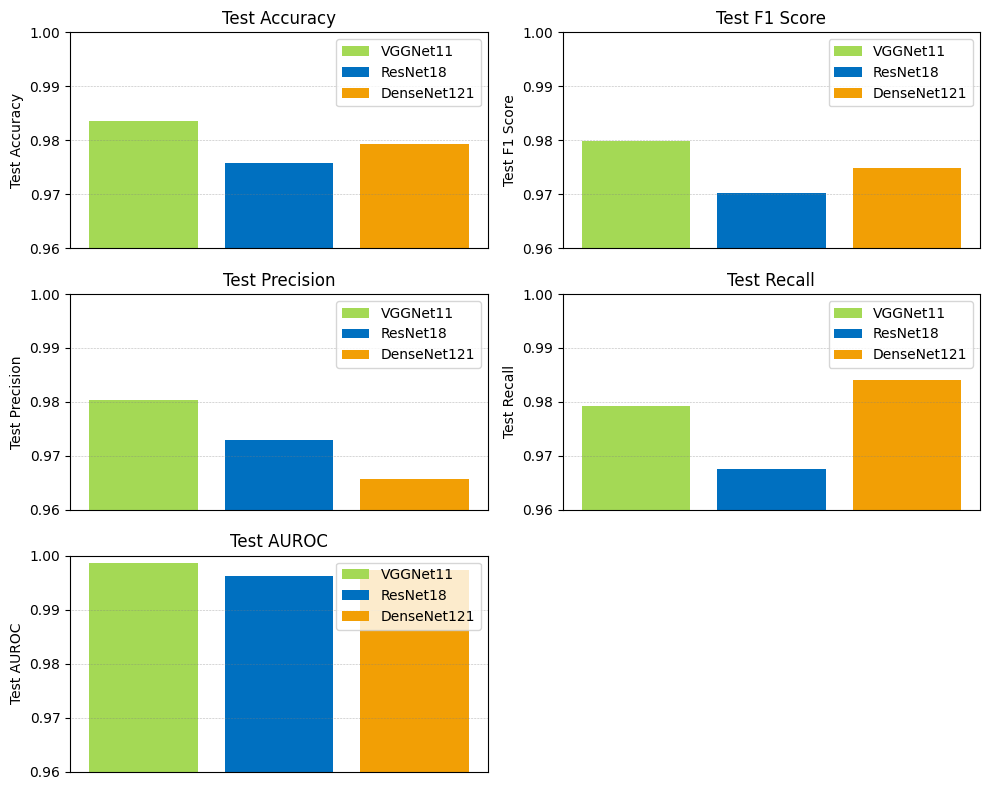

In [14]:
plot_metrics(scores)

Plots the history of the model files

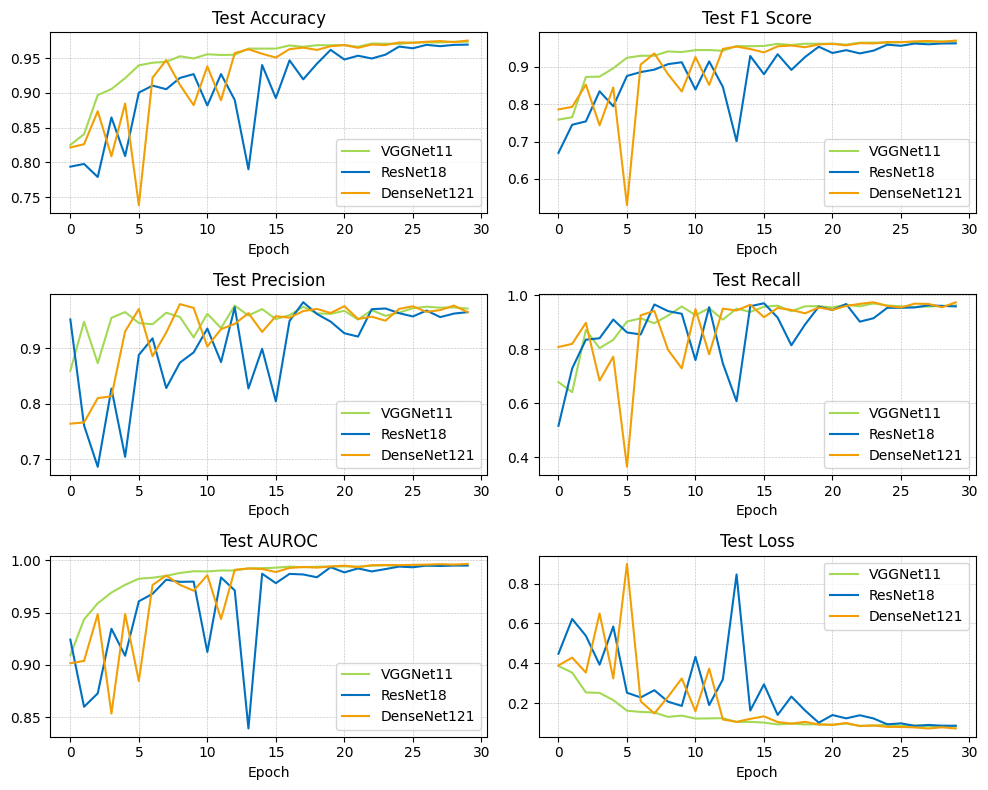

In [15]:
plot_history(nets)